# Learning from Imbalanced Data - Part A

## Tutorial support notebook


This notebook supports the slides of the tutorial on "Learning from Imbalanced Data" that was presented in the 14th International Conference on Information, Intelligence, Systems and Applications (IISA 2023), University of Thessaly, Volos, Greece.

The first part:
* demonstrates the problems caused by data imbalance in the performance of even dummy classification models,
* demonstrates the inappropriateness of the Accuracy measure,
* describes other competitive evaluation measures.


**Author: Leonidas Akritidis**

**Last update: 10/07/2023**


In [1]:
import numpy as np
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# Used for creating training and test sets
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Classification models
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation Measures
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score
from sklearn.metrics import roc_curve, auc, balanced_accuracy_score, classification_report

seed=42
num_samples=1000
imbalance_ratio = [0.95,0.05]
num_classes=len(imbalance_ratio)
oversampling_ratio=1.0

np.random.seed(seed)


## Imbalanced datasets

Let us create two test datasets with 1000 two-dimensional samples. The first one is binary with an imbalance ratio of $19:1$ (i.e. 950 samples are assigned to class 0 and 50 samples are assigned to class 1). The other one includes three classes and has an imbalance relation of $16:3:1$: given 20 randomly selected samples, 16 of them are assinged to class 0, 3 are assigned to class 1, and 1 is assigned to class 2.

<AxesSubplot:>

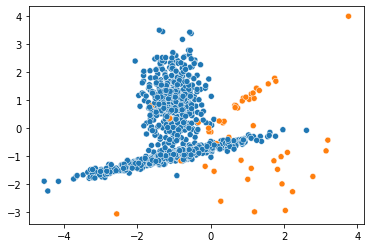

In [2]:
# Binary dataset
binary_dataset = make_classification(n_samples=num_samples, n_features=2, n_classes=2, weights=[0.95,], flip_y=0,
                              n_informative=2, n_clusters_per_class=2, n_redundant=0, n_repeated=0, random_state=seed)

X = binary_dataset[0]
y = binary_dataset[1]
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, legend=False)


<AxesSubplot:>

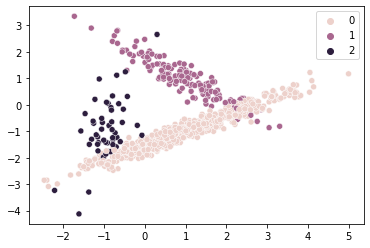

In [3]:
# Multi-class dataset (3 classes)
multi_dataset = make_classification(n_samples=num_samples, n_features=2, n_classes=3, weights=[0.8, 0.15, 0.05], flip_y=0,
                              n_informative=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=seed)

X = multi_dataset[0]
y = multi_dataset[1]

sns.scatterplot(x=X[:,0], y=X[:,1], hue=y)

## Test imbalance dataset with ratio 10:1

Another imbalanced dataset with a class imbalance ratio of 10:1. From 11 randomly selected samples, 10 correspond to the majority class (class 0) and 1 corresponds to the minority class (class 1).

<AxesSubplot:>

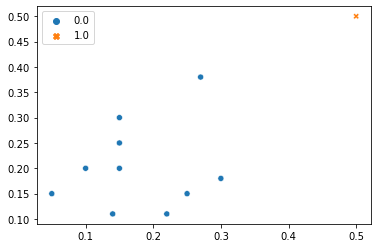

In [4]:
dataset = np.array([ [0.1,0.2,0], [0.15,0.3,0], [0.15,0.25,0], [0.25,0.15,0], [0.05,0.15,0], [0.15,0.20,0], [0.30,0.18,0], [0.22,0.11,0], [0.14,0.11,0], [0.27,0.38,0], [0.5,0.5,1] ] )

sns.scatterplot(x=dataset[:,0], y=dataset[:,1], hue=dataset[:,2], style=dataset[:,2] )


## An example of (random/dummy) classification with imbalanced data

This example demonstrates why the Accuracy measure is inappropriate for evaluating the performance of classification models trained on imbalanced data. We will build a test dataset with 1000 two-dimensional samples and 2 classes. The imbalance ratio is set equal to $19:1$ (i.e. 950 samples are assigned to class 0 and 50 samples are assigned to class 1.

<AxesSubplot:>

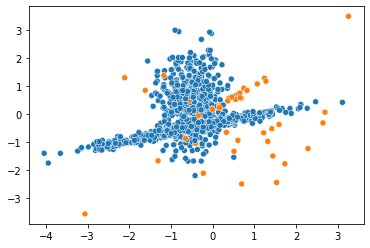

In [5]:
dataset = make_classification(n_samples=num_samples, n_features=2, n_clusters_per_class=2,
                              n_classes=num_classes, weights=imbalance_ratio, flip_y=0, class_sep=0.5,
                              n_informative=2, n_redundant=0, n_repeated=0, random_state=seed)

X = dataset[0]
y = dataset[1]

sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, legend=False)


In [6]:
print("Class Distribution:")

for k in range(num_classes):
    print("Class", k, ":", len(y[y==k]), "samples")

Class Distribution:
Class 0 : 950 samples
Class 1 : 50 samples


In the sequel, we prepare the dataset for classification. We split it into a training and a test set in a ratio $4:1$; in other words, 80% of the original data will be used for training, and 20% will be used for testing. Stratifying by the target variable guarantees that the distributions of the two classes will be (about) the same in the training and test sets.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)


Class 0 : 190 samples
Class 1 : 10 samples


Text(0.5, 1.0, 'Class distribution in the test set\n')

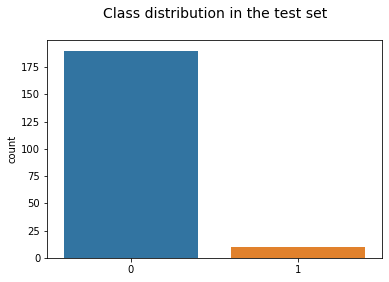

In [8]:
for k in range(num_classes):
    print("Class", k, ":", len(y_test[y_test==k]), "samples")

sns.countplot(x=y_test)
plt.title('Class distribution in the test set\n', fontsize=14)


### A dummy predictor


This dummy predictor always outputs `0`. Even this one receives an accuracy value of $0.95$!

In [9]:
dummy_predictions = np.zeros(y_test.shape[0])

print('Test score: ', accuracy_score(y_test, dummy_predictions))


Test score:  0.95


## Evaluation measures

Other measures must be examined to capture the inability of the dummy classifier to handle the minority samples.

* **Confusion Matrix**: We start with the well-established Confusion Matrix which is defined as follows:

|                             | Predicted Positive Class   | Predicted Negative Class   |
| :----                       | :----:                     | :----:                     |
| **Actual Positive Class**   | True Positive (TP)         | False Negative (FN)        |
| **Actual Negative Class**   | False Positive (FP)        | True Negative (TP)         |

where

* **$TP$ (True Positive)**: the actually positive examples that are correctly predicted as positive.
* **$TN$ (True Negative)**: the actually negative examples that are correctly predicted as negative.
* **$FP$ (False Positive)**: the actually negative examples that are incorrectly predicted as positive.
* **$FN$ (False Negative)**: the actually positive examples that are incorrectly predicted as negative.

Based on these four indicators a rich collection of measures is defined:

* **Accuracy:** For a classification model, Accuracy measures the number of correctly predicted examples among all the total possible examples. Simply, the ratio of the correctly predicted examples to the total number of examples present:

$$\text{Accuracy}=\frac{TP+TN}{TP+TN+FP+FN}$$

* **Precision**: the ratio of true positives $(TP)$ to the total number of positive examples predicted:
\begin{equation}
\text{Precision}=\frac{TP}{TP+FP}
\end{equation}

* **Recall**: the fraction of true positive $(TP)$ examples to all examples that are actually positive:
\begin{equation}
\text{Recall}=\frac{TP}{TP+FN}
\end{equation}

* **F-Measure**: the harmonic mean of Precision and Recall.
\begin{equation}
\text{F1}=\frac{2 \cdot \text{Precision} \cdot \text{Recall} }{\text{Precision}+\text{Recall}}
\end{equation}



If we consider Class 0 to be the Positive Class and Class 1 to be the Negative Class, the Confusion Matrix of the predictions is:


|                      | Predicted Class 0   | Predicted Class 1   |
| :----                | :----:              | :----:              |
| **Actual Class 0**   |         1900        |         0           |
| **Actual Class 1**   |          100        |         0           |


\begin{equation}
\text{Precision}=\frac{TP}{TP+FP}=\frac{1900}{2000}=0.95
\end{equation}

\begin{equation}
\text{Recall}=\frac{TP}{TP+FN}=\frac{1900}{1900+0}=1
\end{equation}

\begin{equation}
\text{F1}=\frac{2 \cdot \text{Precision} \cdot \text{Recall} }{\text{Precision}+\text{Recall}}=\frac{2 \cdot 0.95 \cdot 0.95}{0.95+1.0}\simeq0.97
\end{equation}


In contrast, if we consider Class 0 to be the Positive Class and Class 1 to be the Negative Class, the Confusion Matrix of the predictions is:

|                      | Predicted Class 1   | Predicted Class 0   |
| :----                | :----:              | :----:              |
| **Actual Class 1**   |           0         |         100         |
| **Actual Class 0**   |           0         |         1900        |


\begin{equation}
\text{Precision}=\frac{TP}{TP+FP}=\text{NaN}
\end{equation}

\begin{equation}
\text{Recall}=\frac{TP}{TP+FN}=\frac{0}{0+100}=0
\end{equation}

\begin{equation}
\text{F1}=\frac{2 \cdot \text{Precision} \cdot \text{Recall} }{\text{Precision}+\text{Recall}}=\text{NaN}
\end{equation}


In [10]:
print(confusion_matrix(y_test, dummy_predictions))


[[190   0]
 [ 10   0]]


In [11]:
print(classification_report(y_test, dummy_predictions))


              precision    recall  f1-score   support

           0       0.95      1.00      0.97       190
           1       0.00      0.00      0.00        10

    accuracy                           0.95       200
   macro avg       0.47      0.50      0.49       200
weighted avg       0.90      0.95      0.93       200



In [12]:
print("Precision:", precision_score(y_test, dummy_predictions))
print("Recall:", recall_score(y_test, dummy_predictions))
print("F1:", f1_score(y_test, dummy_predictions))


Precision: 0.0
Recall: 0.0
F1: 0.0


### Other measures

* **Sensitivity, or True Positive Rate $(TPR)$**: the positive examples that are correctly predicted by a model.

$$TPR=\text{Recall}=\frac{TP}{TP+FN}$$

* **Specificity, or True Negative Rate $(TNR)$**: the negative examples that are correctly predicted by a model.

$$TNR=\frac{TN}{TN+FP}$$

* **G-Measure**:

$$G=\sqrt{TPR\cdot TNR}$$

* **Balanced Accuracy** computes the geometric mean of accuracy of minority and majority class. Or else, it is the average of the sum of Sensitivity and Specificity:

$$\text{Balanced Accuracy}=\frac{\text{Sensitivity} + \text{Specificity}}{2}=\frac{TPR+TNR}{2}$$


In [13]:
print("Balanced Accuracy:", balanced_accuracy_score(y_test, dummy_predictions))


Balanced Accuracy: 0.5


## Working with other classifiers

In [14]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=300, random_state=seed),
    "Decision Tree": DecisionTreeClassifier(criterion='gini', max_depth=None, max_features=None, random_state=seed),
    "Random Forest": RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, max_features='sqrt',
                                       n_jobs=8, random_state=seed),
    "SVM (RBF Kernel)": SVC(kernel='rbf', C=1, random_state=seed),
    "FCFF Neural Net:": MLPClassifier(activation='relu', hidden_layer_sizes=(16, 4), solver='adam', random_state=seed),
}

Results = []


Train the classifiers with the training set.

In [15]:
for mdl in models:
    print("\tTraining", mdl + "...\t", end="", flush=True)
    t0 = time.time()

    clf = models[mdl]
    clf.fit(X_train, y_train)

    print(" completed in %5.3f sec." % (time.time() - t0))


	Training Logistic Regression...	 completed in 0.006 sec.
	Training Decision Tree...	 completed in 0.000 sec.
	Training Random Forest...	 completed in 0.069 sec.
	Training SVM (RBF Kernel)...	 completed in 0.004 sec.
	Training FCFF Neural Net:...	 completed in 0.136 sec.


Test the classifier performance with the test set.

In [16]:
for mdl in models:
    print("Testing", mdl + "...\n")
    clf = models[mdl]
    y_predicted = clf.predict(X_test)
    print("\tAccuracy=", accuracy_score(y_test, y_predicted),
          "\n\tBalanced Accuracy:", balanced_accuracy_score(y_test, y_predicted))
    print("\tConfusion Matrix:\n", confusion_matrix(y_test, y_predicted))

Testing Logistic Regression...

	Accuracy= 0.95 
	Balanced Accuracy: 0.5
	Confusion Matrix:
 [[190   0]
 [ 10   0]]
Testing Decision Tree...

	Accuracy= 0.96 
	Balanced Accuracy: 0.6947368421052631
	Confusion Matrix:
 [[188   2]
 [  6   4]]
Testing Random Forest...

	Accuracy= 0.965 
	Balanced Accuracy: 0.65
	Confusion Matrix:
 [[190   0]
 [  7   3]]
Testing SVM (RBF Kernel)...

	Accuracy= 0.96 
	Balanced Accuracy: 0.6
	Confusion Matrix:
 [[190   0]
 [  8   2]]
Testing FCFF Neural Net:...

	Accuracy= 0.955 
	Balanced Accuracy: 0.55
	Confusion Matrix:
 [[190   0]
 [  9   1]]


In [17]:
def plot_decision_regions_2D(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 'o', 'o', 'o', 's', 'v', '^')
    colors = ('#1f77b4', '#ff7f0e', 'red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
    x2_min, x2_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
    
    # meshgrid: Return coordinate matrices from coordinate vectors. More specifically, we make N-D coordinate arrays
    # for vectorized evaluations of N-D scalar/vector fields over N-D grids, given one-dimensional coordinate arrays.
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))

    # ravel: Return a contiguous flattened array.
    # T: the transpose matrix
    X_test_in = np.array([xx1.ravel(), xx2.ravel()]).T
    # print(X_test)

    Z = classifier.predict(X_test_in)
    Z = Z.reshape(xx1.shape)

    plt.contourf(xx1, xx2, Z, alpha=0.15, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl,0], y=X[y==cl,1], alpha=0.8, c=colors[idx], marker=markers[idx], label=cl, edgecolor='white')


In [18]:
def TrainTestModel(train_X, test_X, train_y, test_y, mdl, res, desc):

        print("Training", mdl + "...\t", end="", flush=True)
        t0 = time.time()

        clf = models[mdl]
        clf.fit(train_X, train_y)

        print("  (%5.3f sec). \t" % (time.time() - t0), end="", flush=True)

        y_predicted = clf.predict(test_X)

        acc = accuracy_score(test_y, y_predicted)
        bacc = balanced_accuracy_score(test_y, y_predicted)

        if num_classes == 2:
            fpr, tpr, thresholds = roc_curve(test_y, y_predicted)
            auc_m = auc(fpr, tpr)
        else:
            auc_m = bacc

        print("Accuracy=%5.4f" % acc, "\tBalanced Accuracy=%5.4f"% bacc, "\tAUC=%5.4f" % auc_m)

        res.append([mdl, desc, acc, bacc, auc_m])

        X_stacked = np.vstack((train_X, test_X))
        Y_stacked = np.hstack((train_y, test_y))

        plot_decision_regions_2D(X_stacked, Y_stacked, clf)
        plt.xlabel("x0")
        plt.ylabel("x1")
        plt.title(mdl + " (Accuracy: " + (str)(round(acc, 3)) + ", AUC: " + (str)(round(auc_m, 3)) + ")")
        plt.legend(loc='upper left')


Training Logistic Regression...	  (0.004 sec). 	Accuracy=0.9500 	Balanced Accuracy=0.5000 	AUC=0.5000
Training Decision Tree...	  (0.000 sec). 	Accuracy=0.9600 	Balanced Accuracy=0.6947 	AUC=0.6947
Training Random Forest...	  (0.076 sec). 	Accuracy=0.9650 	Balanced Accuracy=0.6500 	AUC=0.6500
Training SVM (RBF Kernel)...	  (0.000 sec). 	Accuracy=0.9600 	Balanced Accuracy=0.6000 	AUC=0.6000
Training FCFF Neural Net:...	  (0.128 sec). 	Accuracy=0.9550 	Balanced Accuracy=0.5500 	AUC=0.5500


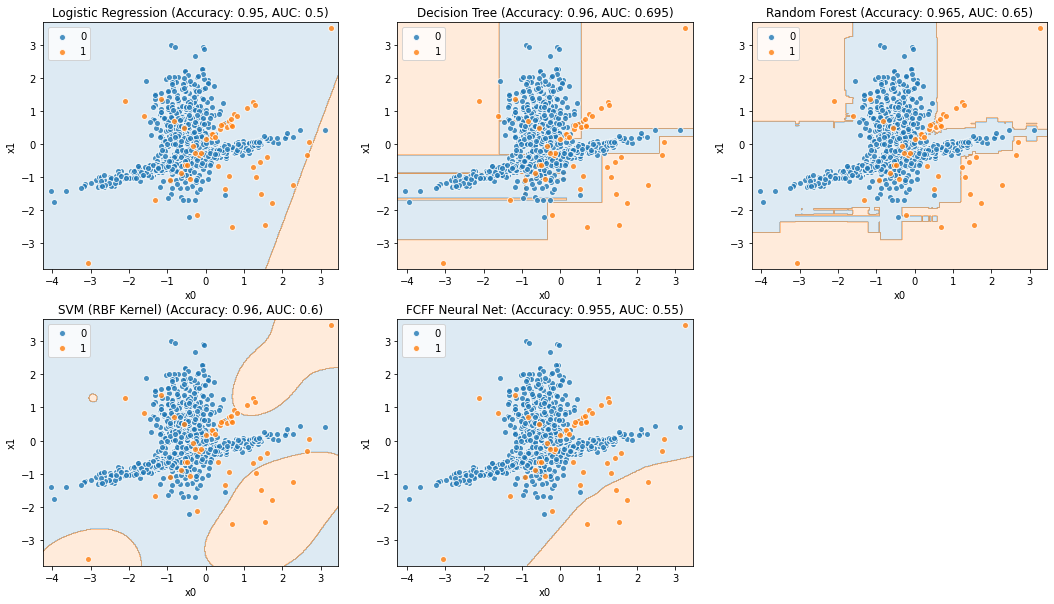

In [19]:
fig = plt.figure(figsize=(18, 10))

itr = 0

for model in models:
    itr = itr + 1
    plt.subplot(2, 3, itr)
    TrainTestModel(X_train, X_test, y_train, y_test, model, Results, "0 - Initial")
